# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
1) Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
2) Контролировать добросовестность кассиров при продаже алкоголя.  

**Цель работы:** построить модель, которая по фотографии определит приблизительный возраст человека. На тестовых данных метрика MAE должна быть менее 7. 

Данные взяты с сайта ChaLearn Looking at People.  
Они находятся в папке /datasets/faces/.  
В папке (/final_files) все изображения и csv-файл labels.csv с двумя колонками: file_name и real_age.  

## Исследовательский анализ данных

### Загрузка и изученные данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
path = '/datasets/faces/'

Загрузим данные с помощью загрузчика. Приведем изображения к размерности 224, 224.

In [2]:
labels = pd.read_csv(path +'labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим на состав выборки.

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В выборке 7591 объект, пропусков нет.

### Анализ возрастов представленных в выборке.

Посмотрим на статистическую информацию о возрасте в выборке.

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В датасете представлены фото с возрастом людей от 1 до 100 лет.

Посмотрим количество уникальных возрастов в датасете.

In [6]:
len(labels['real_age'].unique())

97

Найдем возраст, который не представлен в выборке.

In [7]:
temp_1 = set(labels['real_age'].sort_values().unique())
temp_2 = set([i for i in range(1, 101)])

In [8]:
sorted(temp_2 -temp_1)

[92, 98, 99]

В датасете представлены фото с возрастом людей от 1 до 100 лет. Уникальных значений возраста 97. Отсутствует объекты с возрастом 92, 98, 99 лет. 

Построим график распределения возраста в выборке

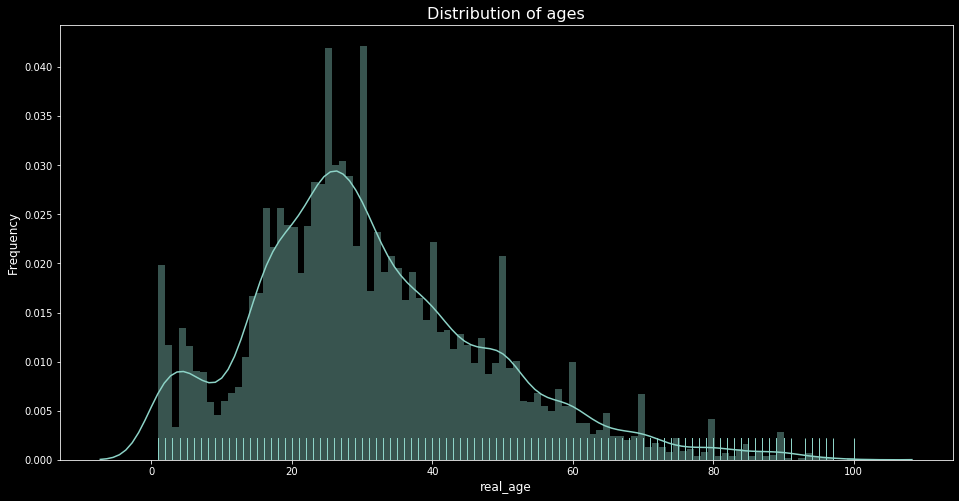

In [9]:
plt.style.use("dark_background")
plt.figure(figsize=(16,8))
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of ages', fontsize=16)
sns.distplot(labels['real_age'], bins=100, rug=True)
plt.show()

In [10]:
labels['real_age'].value_counts().head(2)

30    317
25    315
Name: real_age, dtype: int64

In [11]:
round(len(labels[labels['real_age'] >= 50]) / len(labels['real_age']), 2)

0.15

В распределении возраста наблюдаются выборосы. От нормального распределения его отличают большое количество объектов с возрастом от 1 до 10 лет и удлиненный хвост справа. Средний и медианный возраст равен 31 и 29 соответственно. Имеются два пиковых значения - 30 и 25 лет. Присутствуют локальные пики в "круглых" возрастах (30, 40, 50, 60, 70, 80, 90). Возможно это связано с частичной ручной разметкой данных, когда возраст после 25 лет определялся с округлением до 10. Так же имеется малое число изображений с возрастом 50-100 лет, всего 15% данных. Возможно модель плохо обучится на этих данных, поэтому применим лос-фунцию MSE, которая будет сильнее штрафивать за большие расхождения предсказанного и истинного значения.

Сгенерируем первый батч из 32 признаков и целевых признаков.

In [12]:
features, target = next(train_gen_flow)
print(features.shape) 

(32, 224, 224, 3)


Напечатаем 16 изображений с указанием возраста из первого батча датасета.

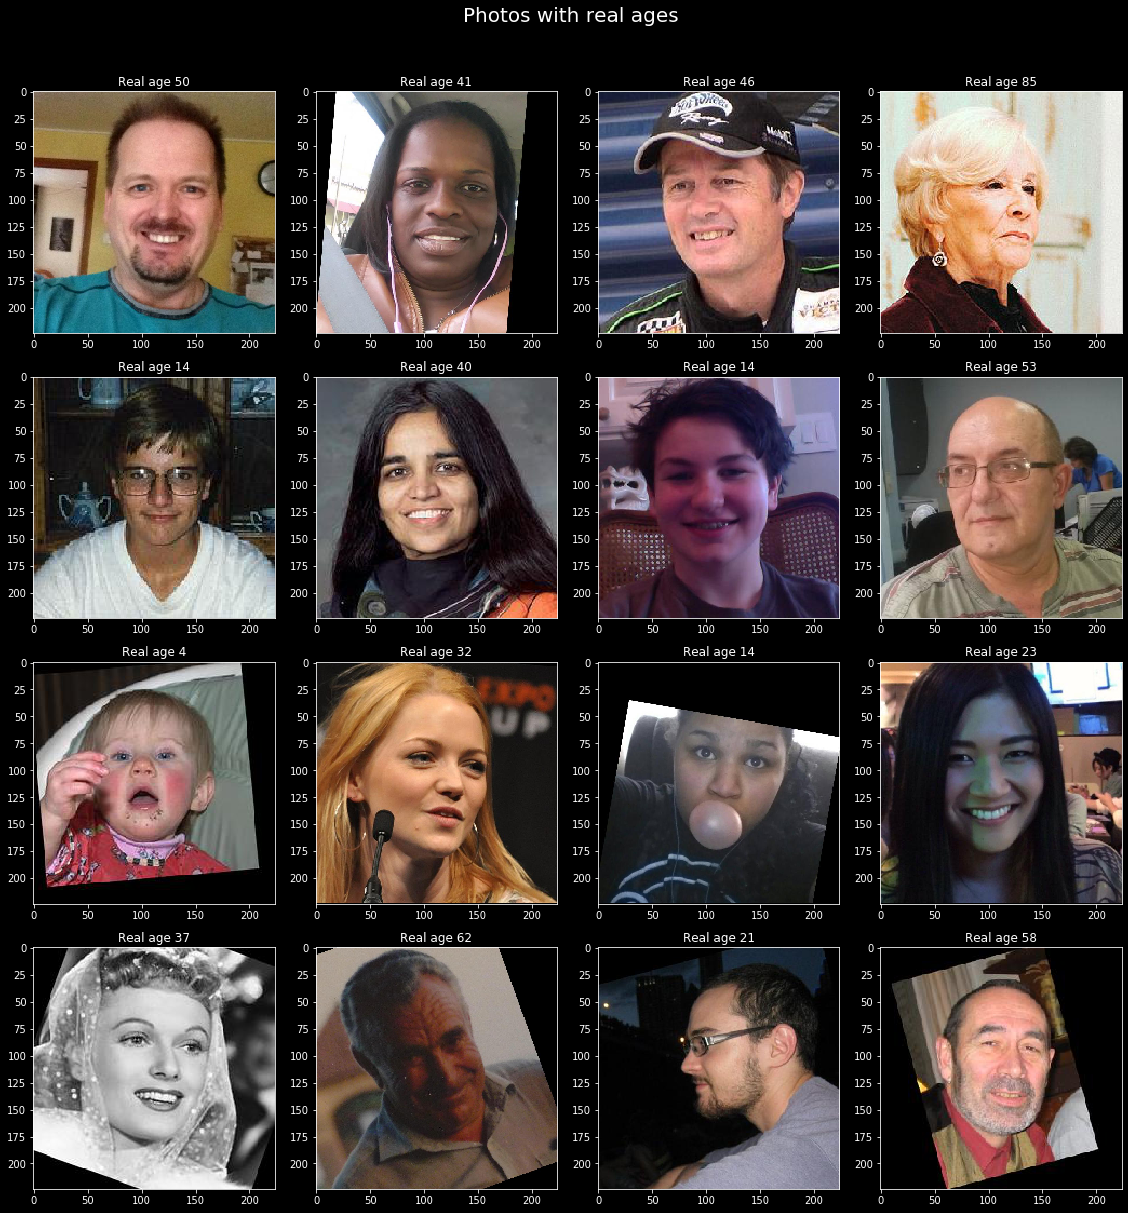

In [13]:
fig = plt.figure(figsize=(16,16))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.title('Real age {}'.format(target[i]))
    plt.imshow(features[i])
    plt.suptitle('Photos with real ages', y=1.05, fontsize=20)
    plt.tight_layout()

Часть избражений повернуто, обрезано и имеет разную яркость используем аугментации с поворотом изображения по горизонтальной оси, вращение на 20 градусов и изменения яркости для повышения качества обучения модели.

## Обучение модели

Напишем четыре функции для обучения модели в GPU-тренажере: 
 1) load_train(path) - загрузка обучающей выборки батчами по 32 изображения и размером 224 на 224 пикселя с горизонтальным отражением изображения. Учтем разбиение выборки на обучающую и валидационную в соотношении 3:1. Это обучающий сабсет.  
 
 2) load_test(path) - аналогично загрузке обучающей выборки, но без аугментаций. Это валидационный сабсет,

 3) create_model(input_shape) - задем модель на основе моели ResNet50, исключая два вехних слоя. Вместо них добавим слои GlobalAveragePooling2D и полносвязный слой Dense с одним выходным нейроном и relu активацией. Так же предварительно загрузим веса для модели ResNet50 чтобы ускорить время обучения.


4) train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps) - обучение модели с валидацией.

Функция загрузки обучающей выборки. Значения цветов в слоях приводим к диапазону от 0 до 1 (делим на 255). Выходные параметры - путь, на выходе загрузчиик тестовой выборки.

In [14]:
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25, 
                                       horizontal_flip=True, 
                                       shear_range=20, 
                                       brightness_range =[0.2, 1.0])
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    return train_gen_flow

Функция для загрузки тестовой выборки. Аналогична загрузке трейн датасета, но без аугментаций.

In [15]:
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_gen_flow 

Функция создания модели. В качестве алгоритма оптимизации используем Adam с исходной скоростью обучения (lr) равной 0,00015. В качестве лос-функции используем MSE (для ускорения обучения), в качестве метрики MAE.    
На входе размер входного изображения (224, 224, 3 в нашем случае), на выходе модель.

In [16]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.00015) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
              metrics=['mae']) 
    return model  

Функция для обучения модели. Обучение модели с использованием возвращенных результатов функций выше. Количество шагов в эпохе и шагов валдации по умолчанию определяется исходя из длины генераторов соответствующих выборок. Размер батча по умолчанию отсутствует, так как выборки подаются загрузчиками с батчем 32. Обучение произведем на 25 эпохах.  
На входе модель, тестовая и валидационная выборка, количество эпох, шагов в эпохе, шагов в валидации, размер батча.

In [17]:
def train_model(model, train_gen_flow, test_gen_flow, epochs=25,
               steps_per_epoch=None, validation_steps=None, batch_size=None):
    if steps_per_epoch == None:
        steps_per_epoch = len(train_gen_flow)
    if validation_steps == None:    
        validation_steps = len(test_gen_flow)
    model.fit(train_gen_flow, 
              validation_data= test_gen_flow,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              batch_size = batch_size,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model       

**Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.**

Train for 178 steps, validate for 60 steps  
Epoch 1/25  
2021-09-24 12:32:02.436863: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10  
2021-09-24 12:32:02.925556: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7  
178/178 - 108s - loss: 205.9247 - mae: 10.5198 - val_loss: 593.5794 - val_mae: 19.3553  
Epoch 2/25  
178/178 - 101s - loss: 93.7646 - mae: 7.3298 - val_loss: 519.8889 - val_mae: 17.4979  
Epoch 3/25  
178/178 - 102s - loss: 73.1520 - mae: 6.4532 - val_loss: 185.8332 - val_mae: 10.4617  
Epoch 4/25  
178/178 - 103s - loss: 58.2176 - mae: 5.7930 - val_loss: 113.4670 - val_mae: 8.0550  
Epoch 5/25  
178/178 - 103s - loss: 48.0356 - mae: 5.2729 - val_loss: 91.5728 - val_mae: 7.2718  
Epoch 6/25  
178/178 - 102s - loss: 37.5653 - mae: 4.7321 - val_loss: 71.4839 - val_mae: 6.3446  
Epoch 7/25  
178/178 - 102s - loss: 32.8164 - mae: 4.4423 - val_loss: 65.9326 - val_mae: 6.0371  
Epoch 8/25  
178/178 - 102s - loss: 29.4950 - mae: 4.1780 - val_loss: 75.5290 - val_mae: 6.3044  
Epoch 9/25  
178/178 - 101s - loss: 24.4282 - mae: 3.8279 - val_loss: 107.6876 - val_mae: 8.2261  
Epoch 10/25  
178/178 - 101s - loss: 24.0426 - mae: 3.7706 - val_loss: 74.8512 - val_mae: 6.3120  
Epoch 11/25  
178/178 - 102s - loss: 24.7436 - mae: 3.7718 - val_loss: 74.8050 - val_mae: 6.2628  
Epoch 12/25  
178/178 - 101s - loss: 19.9195 - mae: 3.4302 - val_loss: 70.2686 - val_mae: 6.2391  
Epoch 13/25  
178/178 - 101s - loss: 18.4478 - mae: 3.2741 - val_loss: 71.1630 - val_mae: 6.4404  
Epoch 14/25  
178/178 - 102s - loss: 16.9284 - mae: 3.1476 - val_loss: 67.8070 - val_mae: 6.1561  
Epoch 15/25  
178/178 - 101s - loss: 15.1803 - mae: 2.9641 - val_loss: 69.7846 - val_mae: 6.2561  
Epoch 16/25  
178/178 - 101s - loss: 13.4789 - mae: 2.8236 - val_loss: 63.0162 - val_mae: 5.8402  
Epoch 17/25  
178/178 - 101s - loss: 12.2284 - mae: 2.6776 - val_loss: 70.4671 - val_mae: 6.2750  
Epoch 18/25  
178/178 - 100s - loss: 11.5103 - mae: 2.5966 - val_loss: 60.0207 - val_mae: 5.7511  
Epoch 19/25  
178/178 - 101s - loss: 11.1104 - mae: 2.5626 - val_loss: 61.5528 - val_mae: 5.7124  
Epoch 20/25  
178/178 - 101s - loss: 12.0823 - mae: 2.6555 - val_loss: 62.7196 - val_mae: 5.8133  
Epoch 21/25  
178/178 - 101s - loss: 11.0153 - mae: 2.5509 - val_loss: 59.8395 - val_mae: 5.8203  
Epoch 22/25  
178/178 - 101s - loss: 11.2662 - mae: 2.5673 - val_loss: 61.4690 - val_mae: 5.7283  
Epoch 23/25  
178/178 - 101s - loss: 10.8334 - mae: 2.5027 - val_loss: 64.5837 - val_mae: 5.9633  
Epoch 24/25  
178/178 - 101s - loss: 9.9881 - mae: 2.4174 - val_loss: 69.9667 - val_mae: 6.1668  
Epoch 25/25  
178/178 - 101s - loss: 9.4764 - mae: 2.3344 - val_loss: 66.8252 - val_mae: 5.9634  
WARNING:tensorflow:sample_weight modes were coerced from  
  ...  
    to   
  ['...']  
60/60 - 9s - loss: 66.8252 - mae: 5.9634  
Test MAE: 5.9634

Визуализируем значение метрики MAE в ходе обучения.

In [18]:
MAE_train = ([10.5198, 7.3298, 6.4532, 5.7930, 5.2729, 4.7321, 4.4423, 
              4.1780, 3.8279, 3.7706, 3.7718, 3.4302, 3.2741, 3.1476, 
              2.9641, 2.8236, 2.6776, 2.5966, 2.5626, 2.6555, 2.5509, 
              2.5673, 2.5027, 2.4174, 2.3344])

MAE_test = ([19.3553, 17.4979, 10.4617, 8.0550, 7.2718,  6.3446, 6.0371,
            6.3044, 8.2261, 6.3120, 6.2628, 6.2391, 6.4404, 6.1561, 
            6.2561, 5.8402, 6.2750, 5.7511, 5.7124, 5.8133, 5.8203, 
            5.7283, 5.9633, 6.1668, 5.9634])

epoch =[_ for _ in range(1, 26)]

In [19]:
result = pd.DataFrame.from_dict({'MAE train subsample': MAE_train, 'MAE test subsample': MAE_test})
result.index = epoch

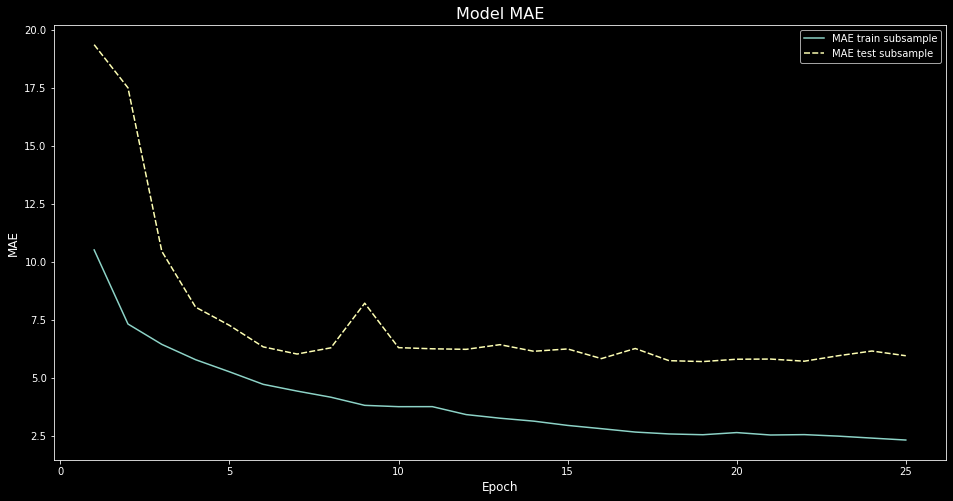

In [20]:
plt.figure(figsize=(16,8))
plt.title('Model MAE', fontsize=16)
plt.ylabel('MAE', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
sns.lineplot(data=result)
plt.show()

## Анализ обученной модели

При обучении модели **после 25 эпох на валидационной выборке достигнуто значение метрики MAE 5,9634**. Модель начала переобучаться уже после первой эпохи, но качество на валидационной выборке непрерывно росло до 7 эпохи, на которой MAE равнялась 6,0371. Далее качество на валидационной выборке начало немного колебаться, но улучшаться в среднем. **Минимальное значение MAE 5,7124 наблюдалось  на 19 эпохе**. 

**В ходе обучения на валидационной выборке удалось выполнить поставленную задачу и достичь метрики MAE ниже 7.**  
Полученная модель позволяет предсказывать возрас покупателя по фото со средней ошибкой ± 5,96 лет.

В недрение системы компьютерного зрения с фотофиксацией и полученной моделью определения возраста по фото позволит супермаркету получить информацию о возрасте покупателей и даст возможности решить поставленные задачи:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  

Контролировать добросовестность кассиров при продаже алкоголя или других товаров с ограниченной продажей можно лишь очень грубо из-за погрешности ± 5,96 лет. В дальнейшем возможно расширить систему компьютерного зрения и обучить модель регрессии или классификации для определения возраста менее 18 или 21 года.   

Кроме решения поставленных задач появится возможность:  
Скорректировать позиционирование бренда, асортимент магазинов и формат рекламных компаний, с учетом преобладания определенных возрастных групп или для привлечения новых групп клиентов. 